<a href="https://colab.research.google.com/github/SherinJA/Parallel-Ant-Colony-Optimization/blob/master/Parallel_Ant_Colony_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Sequential ACO...
Sequential Execution Time: 209.7469 seconds
Best path: [239, np.int64(368), np.int64(137), np.int64(150), np.int64(314), np.int64(143), np.int64(242), np.int64(356), np.int64(247), np.int64(409), np.int64(328), np.int64(179), np.int64(25), np.int64(372), np.int64(172), np.int64(216), np.int64(382), np.int64(294), np.int64(395), np.int64(73), np.int64(373), np.int64(85), np.int64(208), np.int64(447), np.int64(374), np.int64(317), np.int64(252), np.int64(426)]
Path length: 96.34332617652764


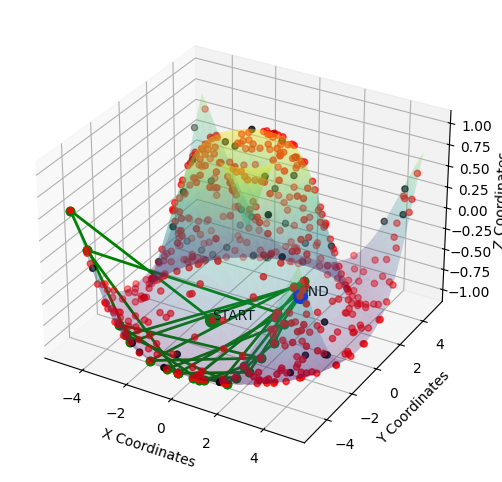


Running Parallel ACO...
Parallel Execution Time: 50.6056 seconds
Best path: [239, 52, 257, 128, 97, 374, 150, 314, 143, 242, 356, 247, 409, 328, 179, 25, 368, 137, 172, 216, 382, 294, 395, 73, 373, 85, 208, 447, 372, 317, 252, 426]
Path length: 111.554681785517


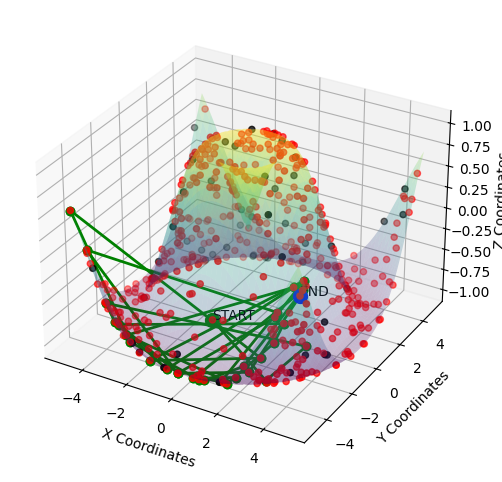


Speedup (Sequential / Parallel): 4.14x


In [ ]:
# !pip install --upgrade plotly
# !pip install jupyter-dash
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10004949 - PAPER

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots
import math
import random
import time
from multiprocessing import Pool

# Define slope function (fixed syntax error)
def get_slope(point1, point2):
    dx = point2[0] - point1[0]
    if dx == 0:  # Avoid division by zero
        return float('inf')
    return (point2[1] - point1[1]) / dx

# Calculate Euclidean distance for 3D points
def distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2 + (point2[2] - point1[2])**2)

# Calculate edge value
def find_edge_val(point1, point2, pheromone_val, alpha, beta):
    slope = get_slope(point1, point2)
    dist = distance(point1, point2)
    if slope == float('inf') or dist == 0:  # Avoid invalid values
        return -float('inf')
    return (1 / slope) + (pheromone_val ** alpha) / (dist ** beta)

# Sequential ACO
def ant_colony_optimization(X, Y, Z, valid_points, obstacles, start_index, end_index, n_ants, n_iterations, alpha, beta, evaporation_rate, Q):
    n_points = len(valid_points)
    pheromone = np.ones((n_points, n_points))
    best_path = None
    best_path_length = np.inf

    for iteration in range(n_iterations):
        paths = []
        path_lengths = []

        for ant in range(n_ants):
            visited = [False] * n_points
            visited[start_index] = True
            current_point = start_index
            path = [current_point]
            path_length = 0

            while path[-1] != end_index:
                r = round(random.uniform(0, 1), 2) #A random number between 0 and 1, rounded to 2 decimals
                chosen_next_point = None
                unvisited_indices = np.where(np.logical_not(visited))[0] #Array of indices of points the ant hasn’t visited yet.

                if r == 0.01:
                    chosen_next_point = random.choice(unvisited_indices)
                else:
                    max_EV = -math.inf
                    for next_point in unvisited_indices:
                        if valid_points[next_point] in obstacles:
                            continue
                        edge_val = find_edge_val(valid_points[current_point], valid_points[next_point], pheromone[current_point, next_point], alpha, beta)
                        if edge_val > max_EV:
                            max_EV = edge_val
                            chosen_next_point = next_point

                if chosen_next_point:
                    pheromone[current_point, chosen_next_point] += Q / n_points
                    pheromone[current_point, chosen_next_point] -= 0.5
                    path.append(chosen_next_point)
                    path_length += distance(valid_points[current_point], valid_points[chosen_next_point])
                    visited[chosen_next_point] = True
                    current_point = chosen_next_point

            paths.append(path)
            path_lengths.append(path_length)

            if path_length < best_path_length:
                best_path = path
                best_path_length = path_length

        pheromone *= evaporation_rate
        for path, path_length in zip(paths, path_lengths):
            for i in range(len(path) - 1):
                pheromone[path[i], path[i + 1]] += Q / path_length

    return best_path, best_path_length

# Parallel ACO ant task
def ant_task(args):
    valid_points, obstacles, start_index, end_index, pheromone, alpha, beta, Q, n_points = args
    visited = [False] * n_points
    visited[start_index] = True
    current_point = start_index
    path = [current_point]
    path_length = 0

    while path[-1] != end_index:
        r = round(random.uniform(0, 1), 2)
        chosen_next_point = None
        unvisited_indices = [i for i in range(n_points) if not visited[i]]

        if not unvisited_indices:
            break

        if r == 0.01:
            chosen_next_point = random.choice(unvisited_indices)
        else:
            max_EV = -math.inf
            for next_point in unvisited_indices:
                if valid_points[next_point] in obstacles:
                    continue
                edge_val = find_edge_val(valid_points[current_point], valid_points[next_point], pheromone[current_point, next_point], alpha, beta)
                if edge_val > max_EV:
                    max_EV = edge_val
                    chosen_next_point = next_point

        if chosen_next_point is None:
            break

        path.append(chosen_next_point)
        path_length += distance(valid_points[current_point], valid_points[chosen_next_point])
        visited[chosen_next_point] = True
        current_point = chosen_next_point

    return path, path_length

# Parallel ACO
def ant_colony_optimization_parallel(X, Y, Z, valid_points, obstacles, start_index, end_index, n_ants, n_iterations, alpha, beta, evaporation_rate, Q):
    n_points = len(valid_points)
    pheromone = np.ones((n_points, n_points))
    best_path = None
    best_path_length = float('inf')

    with Pool(processes=4) as pool:
        for iteration in range(n_iterations):
            ant_args = [(valid_points, obstacles, start_index, end_index, pheromone, alpha, beta, Q, n_points) for _ in range(n_ants)]
            results = pool.map(ant_task, ant_args)
            paths, path_lengths = zip(*results)

            for path, path_length in zip(paths, path_lengths):
                if path[-1] == end_index and path_length < best_path_length:
                    best_path = path
                    best_path_length = path_length

            pheromone *= evaporation_rate
            for path, path_length in zip(paths, path_lengths):
                if path[-1] == end_index:
                    for i in range(len(path) - 1):
                        pheromone[path[i], path[i + 1]] += Q / path_length

    return best_path, best_path_length

# Plotting function (shared for both)
def plot_result(X, Y, Z, valid_points, obstacles, best_path, best_path_length):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.25)

    x_pts = [coord[0] for coord in valid_points]
    y_pts = [coord[1] for coord in valid_points]
    z_pts = [coord[2] for coord in valid_points]
    x_obs = [coord[0] for coord in obstacles]
    y_obs = [coord[1] for coord in obstacles]
    z_obs = [coord[2] for coord in obstacles]

    ax.scatter(x_pts, y_pts, z_pts, c='r', marker='o')
    ax.scatter(x_obs, y_obs, z_obs, c='k', marker='o')

    print('Best path:', best_path)
    print('Path length:', best_path_length)

    ax.scatter(valid_points[best_path[0]][0], valid_points[best_path[0]][1], valid_points[best_path[0]][2], c='g', marker='o', s=100, label='START')
    ax.text(valid_points[best_path[0]][0], valid_points[best_path[0]][1], valid_points[best_path[0]][2], 'START', color='black')
    ax.scatter(valid_points[best_path[-1]][0], valid_points[best_path[-1]][1], valid_points[best_path[-1]][2], c='b', marker='o', s=100, label='END')
    ax.text(valid_points[best_path[-1]][0], valid_points[best_path[-1]][1], valid_points[best_path[-1]][2], 'END', color='black')

    for i in range(len(best_path) - 1):
        ax.plot([valid_points[best_path[i]][0], valid_points[best_path[i + 1]][0]],
                [valid_points[best_path[i]][1], valid_points[best_path[i + 1]][1]],
                [valid_points[best_path[i]][2], valid_points[best_path[i + 1]][2]],
                c='g', linestyle='-', linewidth=2, marker='o')

    ax.set_xlabel('X Coordinates')
    ax.set_ylabel('Y Coordinates')
    ax.set_zlabel('Z Coordinates')
    plt.show()

# Setup mountain and points
def mountain_surface(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = mountain_surface(X, Y)

np.random.seed(0)
points = np.random.choice(X.size, size=500, replace=False) #points becomes a 1D array of 500 indices
x_points = X.flat[points]
y_points = Y.flat[points]
z_points = Z.flat[points]

# The .flat attribute in NumPy converts a multi-dimensional array (like a 2D array) into a
# 1D iterator or view of its elements, as if you “flattened” it into a single line.
# It doesn’t create a new array by default—it provides a way to access the elements in a linear sequence.

obstacle_count = int(0.1 * len(points))
obstacle_indices = np.random.choice(len(points), size=obstacle_count, replace=False)
obstacle_x = x_points[obstacle_indices]
obstacle_y = y_points[obstacle_indices]
obstacle_z = z_points[obstacle_indices]
obstacles = [(x, y, z) for x, y, z in zip(obstacle_x, obstacle_y, obstacle_z)] #pairs up the 50 x, y, and z values into tuples.

non_obstacle_x = np.delete(x_points, obstacle_indices)
non_obstacle_y = np.delete(y_points, obstacle_indices)
non_obstacle_z = np.delete(z_points, obstacle_indices)
non_obstacles = [(x, y, z) for x, y, z in zip(non_obstacle_x, non_obstacle_y, non_obstacle_z)]

start_point_index = np.random.randint(len(non_obstacles))
end_point_index = np.random.randint(len(non_obstacles))
while start_point_index == end_point_index:
    start_point_index = np.random.randint(len(non_obstacles))
    end_point_index = np.random.randint(len(non_obstacles))

np.seterr(divide='ignore')

# Measure execution time for sequential version
print("Running Sequential ACO...")
start_time_seq = time.time()
best_path_seq, best_path_length_seq = ant_colony_optimization(X, Y, Z, non_obstacles, obstacles, start_point_index, end_point_index,
                                                              n_ants=5, n_iterations=50, alpha=1, beta=1, evaporation_rate=0.5, Q=1)
end_time_seq = time.time()
seq_time = end_time_seq - start_time_seq
print(f"Sequential Execution Time: {seq_time:.4f} seconds")
plot_result(X, Y, Z, non_obstacles, obstacles, best_path_seq, best_path_length_seq)

# Measure execution time for parallel version
print("\nRunning Parallel ACO...")
start_time_par = time.time()
best_path_par, best_path_length_par = ant_colony_optimization_parallel(X, Y, Z, non_obstacles, obstacles, start_point_index, end_point_index,
                                                                       n_ants=5, n_iterations=50, alpha=1, beta=1, evaporation_rate=0.5, Q=1)
end_time_par = time.time()
par_time = end_time_par - start_time_par
print(f"Parallel Execution Time: {par_time:.4f} seconds")
plot_result(X, Y, Z, non_obstacles, obstacles, best_path_par, best_path_length_par)

# Compare execution times
print(f"\nSpeedup (Sequential / Parallel): {seq_time / par_time:.2f}x")